# Example of spatial analysis on a region in pancreatic cancer

In [1]:
from pathlib import Path
import tumor_microenv as tm

In [2]:
data_root = Path("data") / "Data"
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0, 
    marker_positive=1, 
    marker_negative=7,
    marker_neg_thresh=0.3,
)
patches, cells = loader()
# Optionally filter cells by some condition.
cells = [c for c in cells if c.cell_type in {"cd4", "cd8", "cd16", "cd163"}]

In [3]:
# This mpp is probably wrong... but let's see what happens.
tm.run_spatial_analysis(
    patches, 
    cells, 
    microenv_distances=[10, 25, 50, 75, 100], 
    mpp=0.254, # TODO: check this value.
    output_path="output.csv")

Distance = 10 um (39 px)
Distance = 25 um (98 px)
Distance = 50 um (197 px)
Distance = 75 um (295 px)
Distance = 100 um (394 px)


In [4]:
!du -sh output.csv

24M	output.csv


## Plot results

We plot a random point from each cell. This makes it easier to visualize the results.

In [5]:
import itertools
import random
import matplotlib.pyplot as plt

def gen_random_point_per_cell(points_data):
    for uuid, g in itertools.groupby(points_data, lambda p: p.cell_uuid):
        yield random.choice(list(g))

def plot(patches, points_data):
    import shapely.wkt
    
    tumor_colors = {
        tm._BiomarkerStatus.NA: "white",
        tm._BiomarkerStatus.POSITIVE: "brown",
        tm._BiomarkerStatus.NEGATIVE: "cyan",
    }

    cell_colors = {
        "cd4": "black",
        "cd8": "purple",
        "cd16": "yellow",
        "cd163": "yellow",
    }
    for patch in patches:
        # Plot tumor patches.
        if patch.patch_type == tm._PatchType.TUMOR:
            plt.fill(*patch.polygon.exterior.xy, color=tumor_colors[patch.biomarker_status])
    # Plot the point we are interested in.
    for point_data in points_data:
        point = shapely.wkt.loads(point_data.point)
        # Plot line to the nearest marker-positive region.
        line_to_pos = shapely.wkt.loads(point_data.line_to_marker_pos)
        plt.plot(*line_to_pos.xy, color="brown", linestyle="--", linewidth=1, alpha=0.4)
        # Plot line to the nearest marker-negative region.
        line_to_neg = shapely.wkt.loads(point_data.line_to_marker_neg)
        plt.plot(*line_to_neg.xy, color="cyan", linestyle="--", linewidth=1, alpha=0.4)
        # Plot the point on top of the two lines.
        plt.plot(point.x, point.y, color=cell_colors[point_data.cell_type], 
                 marker="o", label=point_data.cell_type)

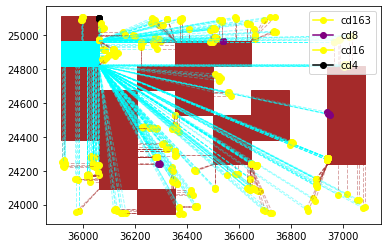

In [6]:
points_data = tm.read_point_csv("output.csv")
random_points_per_cell = list(gen_random_point_per_cell(points_data))
plot(patches, random_points_per_cell)

# Get unique legend labels. See https://stackoverflow.com/a/13589144/5666087
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=1)
plt.show()